# 19th Century English Reference Corpus

### First of all I import all the packages I need and create the stopword list

In [1]:
import glob

import sys
# !{sys.executable} -m spacy download en
import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 
                   'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come', 'would', 'could', 'get'
                   , 'come', 'may', 'say', 'jennie', 'nutkin', 'gluck', 'arbor', 'smooch', 'hunca_munca', 
                   'lily', 'crosbie', 'same', 'bernard', 'johnny', 'cradell', 'hopkin', 'lily_dale', 'griseld', 'allan', 'alice', 'noel',
                   'robert', 'dicky', 'alicia', 'cuckoo', 'cnut', 'norman', 'deronda', 'harry, margaret', 'gwendolen', 'ethel', 'isabel',
                   'toady_lion', 'dissy', 'madame_merle', 'lord_warburtan', 'pansy', 'isabel', 'barrymore', 'sir_charle', 'dr_mortimer',
                   'watson', 'moor', 'catherine', 'heathcliff', 'linton', 'great', 'never','much','shall','well', 'find', 'give', 'ebbo','grandcourt', 'william',
                  'mary','quite','turn','maisie','thornton','philip', 'dorothea', 'tom','_', 'loman', 'doctor','oliver','stephen','maggie','tess','back', 
                  'little', 'thing', 'ready', 'cuthberg','make','must','pass','jurgi', 'osborne','marija',
                  'rawdon','vivian', 'miss_halcombe','jos','osborne', 'fairlie', 'beckendorff',
                  'lady_glyde', 'sir_percival', 'crawley', 'mrs', 'mr', 'arbace', 'ione', 'claucus', 'lucy'])

%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

In [5]:
textfiles = glob.glob("19Creference/*txt") # list files in local directory 

In [6]:
textList=[]
for textFile in textfiles: # create a list 
    f = open(textFile, "r")
    textList = textList + [f.read().upper()]
    f.close()
len(textList)

60

# Pre-processing the texts

### First, I tokenize the texts, removing punctuation and unnessecary characters

In [7]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  
data_words = list(sent_to_words(textList))

In [8]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

### Building bigram and trigram models, words that are likely to occur together

In [ ]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

### Remove stopwords, make bigrams and bigrams and lemmatize

In [10]:
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
        # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

### Create dictionary and corpus needed for the Topic Model, build LDA model

In [14]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           update_every=1,
                                           chunksize=100,
                                           passes=5,
                                           alpha='symmetric',
                                           iterations=10,
                                           per_word_topics=True)

### View the top 10 topics in the LDA model

In [15]:
pprint(lda_model.print_topics())

[(0,
  '0.012*"man" + 0.009*"day" + 0.008*"time" + 0.008*"life" + 0.008*"hand" + '
  '0.007*"eye" + 0.006*"nothing" + 0.006*"house" + 0.006*"face" + '
  '0.005*"lady"'),
 (1,
  '0.012*"man" + 0.010*"time" + 0.007*"hand" + 0.007*"room" + 0.007*"lady" + '
  '0.006*"house" + 0.006*"day" + 0.006*"eye" + 0.006*"woman" + 0.006*"life"'),
 (2,
  '0.016*"man" + 0.011*"time" + 0.008*"day" + 0.006*"house" + 0.006*"night" + '
  '0.006*"way" + 0.006*"hand" + 0.005*"people" + 0.005*"eye" + 0.005*"place"'),
 (3,
  '0.012*"time" + 0.011*"man" + 0.008*"day" + 0.007*"hand" + 0.006*"house" + '
  '0.006*"way" + 0.006*"eye" + 0.006*"moment" + 0.005*"night" + 0.005*"woman"'),
 (4,
  '0.016*"man" + 0.012*"time" + 0.010*"day" + 0.007*"eye" + 0.006*"house" + '
  '0.006*"hand" + 0.006*"door" + 0.005*"woman" + 0.005*"life" + 0.005*"word"'),
 (5,
  '0.013*"time" + 0.010*"man" + 0.009*"lady" + 0.008*"house" + 0.008*"way" + '
  '0.008*"nothing" + 0.006*"room" + 0.006*"friend" + 0.006*"hand" + '
  '0.006*"day"'),
 (

# Visualization

## Word clouds of top n keywords in each topic

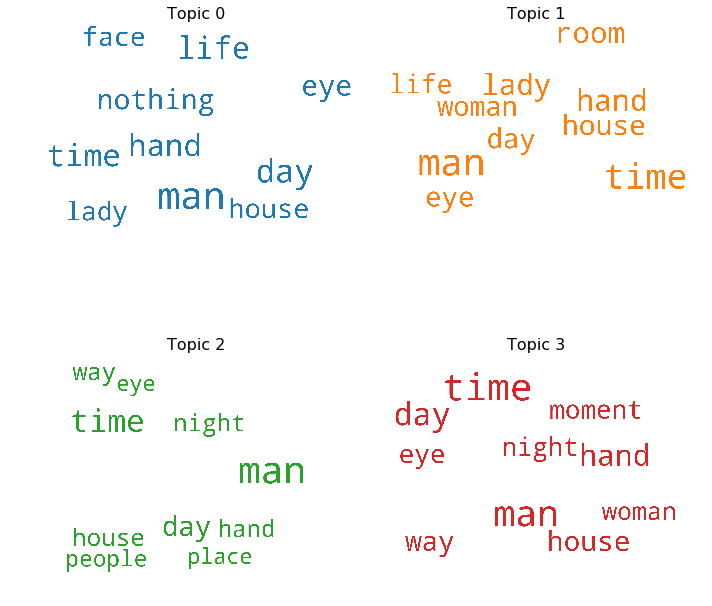

In [16]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

## Dominant topic and its percentage contribution in each document

In [17]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=textList):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,8.0,0.1686,"man, time, day, lady, way, word, friend, nothi...","[anne, bronte, chapter, parsonage, history, in..."
1,1,8.0,0.7170,"man, time, day, lady, way, word, friend, nothi...","[house, allington, anthony, trollope, chapter,..."
2,2,2.0,0.3925,"man, time, day, house, night, way, hand, peopl...","[note, circulation, charles_dicken, book, frie..."
3,3,1.0,0.5034,"man, time, hand, room, lady, house, day, eye, ...","[rome, wilkie, chapter, goisvintha, mountain, ..."
4,4,9.0,0.3713,"man, day, time, hand, life, way, father, eye, ...","[armadale, wilkie, chapter, traveler, season, ..."
5,5,2.0,0.5789,"man, time, day, house, night, way, hand, peopl...","[awakening, story, chapter, cage, door, allez,..."
6,6,0.0,0.2798,"man, day, time, life, hand, eye, nothing, hous...","[hound, baskerville, arthur, conan, doyle, cha..."
7,7,4.0,0.6992,"man, time, day, eye, house, hand, door, woman,...","[ghost, story, christma, charles_dicken, prefa..."
8,8,3.0,0.5960,"time, man, day, hand, house, way, eye, moment,...","[cranford, elizabeth, chapter, society, place,..."
9,9,7.0,0.3599,"time, man, hand, eye, day, life, heart, room, ...","[chapter, man, nothing, science, measurer, sta..."


## pyLDAVIS: Visualise the information contained in a topic 

In [18]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8     -0.046110  0.007053       1        1  14.162022
7      0.014185 -0.026664       2        1  11.830256
2      0.023744  0.034585       3        1  11.468654
4      0.017626 -0.003007       4        1  10.782711
9     -0.007684 -0.016859       5        1  10.745940
3      0.000537  0.002529       6        1  10.314370
5     -0.026144  0.006218       7        1   9.672032
1     -0.001098 -0.002898       8        1   8.131210
0      0.014250 -0.007324       9        1   6.913424
6      0.010694  0.006367      10        1   5.979377, topic_info=      Category          Freq       Term         Total  loglift  logprob
2859   Default    731.000000     audley    731.000000  30.0000  30.0000
22148  Default    713.000000     gerald    713.000000  29.0000  29.0000
17716  Default    733.000000       jude    733.000000  28.0000  28.0000
1358   Default   7601.000000       lady   7601.000000  27.0000  27.0000
19815  Default    660.000000     elinor    660.000000  26.0000  26.0000
31764  Default    506.000000     birkin    506.000000  25.0000  25.0000
1107   Default   9750.000000       hand   9750.000000  24.0000  24.0000
1405   Default   7513.000000       life   7513.000000  23.0000  23.0000
24645  Default    532.000000   marianne    532.000000  22.0000  22.0000
14610  Default    883.000000       emma    883.000000  21.0000  21.0000
1454   Default  17928.000000        man  17928.000000  20.0000  20.0000
19627  Default    635.000000   casaubon    635.000000  19.0000  19.0000
20098  Default    642.000000    lydgate    642.000000  18.0000  18.0000
15533  Default    461.000000        sue    461.000000  17.0000  17.0000
582    Default    818.000000       dale    818.000000  16.0000  16.0000
878    Default   8441.000000        eye   8441.000000  15.0000  15.0000
5458   Default    531.000000   caroline    531.000000  14.0000  14.0000
22337  Default    442.000000    shirley    442.000000  13.0000  13.0000
1737   Default   5201.000000     people   5201.000000  12.0000  12.0000
1611   Default   7558.000000    nothing   7558.000000  11.0000  11.0000
19604  Default    513.000000  bulstrode    513.000000  10.0000  10.0000
2100   Default   7153.000000       room   7153.000000   9.0000   9.0000
23153  Default    523.000000    glaucus    523.000000   8.0000   8.0000
21177  Default    711.000000   tulliver    711.000000   7.0000   7.0000
880    Default   5785.000000       face   5785.000000   6.0000   6.0000
6542   Default    554.000000     rachel    554.000000   5.0000   5.0000
2792   Default    955.000000     amelia    955.000000   4.0000   4.0000
594    Default  12164.000000        day  12164.000000   3.0000   3.0000
21191  Default    337.000000     ursula    337.000000   2.0000   2.0000
1541   Default   5876.000000     moment   5876.000000   1.0000   1.0000
...        ...           ...        ...           ...      ...      ...
2181   Topic10    172.119904    servant   1642.842041   0.5609  -6.2392
600    Topic10    222.579010      death   2350.604980   0.4597  -5.9821
397    Topic10    387.083130      child   5073.390137   0.2437  -5.4288
878    Topic10    556.307556        eye   8441.309570   0.0973  -5.0661
2100   Topic10    482.730591       room   7153.198242   0.1210  -5.2079
591    Topic10    108.472122   darkness    883.465637   0.7195  -6.7009
1782   Topic10    433.482391      place   6261.180176   0.1466  -5.3155
1040   Topic10    314.038940       girl   4030.567871   0.2647  -5.6379
1550   Topic10    333.385620    morning   4445.072266   0.2266  -5.5781
725    Topic10    393.815582       door   5740.720215   0.1374  -5.4115
1002   Topic10    429.557281     friend   6533.872070   0.0949  -5.3246
2492   Topic10    758.102234       time  15531.038086  -0.2029  -4.7566
880    Topic10    393.262634       face   5785.327637   0.1283  -5.4129
2652   Topic10    508.144073        way   8595.379883  -0.0114  -5.15